# RQ 1: Search Engine Analysis

In this section we are going to use skitlearn's tf-idf vectorizer and gensim for the word2vec model. First of all copy the search engine to this folder and import what we need:

In [237]:
!cp ../search-engine/search_engine.py ../notebook/

In [116]:
import json
import gzip
import re
import collections
import math
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from operator import itemgetter
from search_engine import load_data, id_to_tweetinfo, text_to_id, create_index_tfidf, generate_tweet_scores, search, getTerms

## 1: TF-IDF + Cosine Similarity Score


In [3]:
data = load_data("../data/tweets_collection_v1.json.gz")
# generate tweets info dictionary
tweets_dict = id_to_tweetinfo(data)
# genetate id to text dictionary
textsdict = text_to_id(tweets_dict)
index, tf, df, idf = create_index_tfidf(textsdict, len(textsdict))
rt, favs = generate_tweet_scores(tweets_dict)

If we take a look at the words with higher idf, we get the following:

In [49]:
sorted(idf, key=idf.get, reverse=True)[0:50]

['news-lett',
 'neath',
 'talbot',
 '#kurdistan',
 '356',
 '99,214',
 'r3500',
 '17million',
 '3yr',
 '@andypopeinthew1',
 'unelected…',
 'lasts.',
 '@teamisf_',
 'transmission,…',
 'iceg',
 'veena',
 'sriram,',
 '@gmanew',
 'door;',
 '“definit',
 'probably”',
 '@jsafc11',
 '@wedoingavilla',
 '@one_voice_430',
 '6.31am,',
 '#hearye,',
 '@sfwdistrict',
 '#flushingforward',
 'millennials:',
 'jewelleri',
 'week"…',
 'why,"',
 'dem.',
 'netw…',
 '@jonesy2167',
 'over."…',
 '@karenwigg1',
 '@deasy_dian',
 'mum’',
 'fortun…',
 'extra…',
 '“inadvertently”!',
 'choice,"',
 '.@rondesantisfl',
 'gobe',
 'teleprese…',
 '~60,000',
 '~50,000',
 '~30,000',
 'grit,']

In [42]:
sorted(df, key=df.get, reverse=True)[0:50]

['covid',
 'covid-19',
 'vaccin',
 'pandem',
 'peopl',
 'get',
 '#covid19',
 '-',
 '&amp;',
 'new',
 'like',
 'coronaviru',
 'health',
 'say',
 'go',
 'one',
 'test',
 'need',
 'first',
 'lockdown',
 'us',
 'take',
 'case',
 'time',
 'work',
 'know',
 'make',
 'would',
 'death',
 'year',
 'day',
 'think',
 'want',
 'trump',
 'see',
 'approv',
 'it’',
 'still',
 'canada',
 'die',
 'mani',
 'even',
 'help',
 'use',
 'look',
 'uk',
 '@realdonaldtrump',
 'pleas',
 'thank',
 'report']

More visually, in a wordcloud (obviously using the processed words)

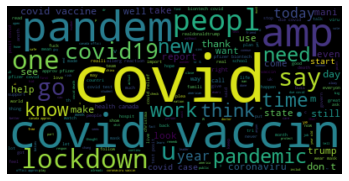

In [85]:
# lower max_font_size
wordcloud = WordCloud().generate(' '.join([getTerms(text, False) for text in list(textsdict.values())]))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
queries = [
    "Ask governor about covid",
    "Covid is an invention of the chinese",
    "Can we cure covid?",
    "What does trump does",
    "Millenials health issues",
    "Is there a law for the lockdown",
    "Take care of ourselves",
    "Is it legal to not wear mask",
    "Covid situation in cana",
    "For how long are we on lockdown?"   
]

In [6]:
for query in queries:
    print("\n==================================================================\n")
    print("Query: ", query)
    ranked_docs = search(query, index, idf, tf, rt, favs, 1) 
    for tweet_id in ranked_docs[:20]:
        tweet_object = tweets_dict[tweet_id]
        txt = tweet_object["text"]
        print("Tweet: %s"%(txt))



Query:  Ask governor about covid
Tweet: Your twenties now extend to 32 to cover time lost to covid
Tweet: Bro Covid or not can people stop fucking standing so god damn close to me fuck.
Tweet: Covid has taught me three things:

1. Our economy collapses as soon as it stops selling useless stuff to over indeb… https://t.co/Eqn38QYeuy
Tweet: COVID SURVIVORS AND THEIR EXPERIENCES WITH LONG TERM EFFECTS, A THREAD:
Tweet: Congress must now do a Covid Relief Bill. Needs Democrats support. Make it big and focused. Get it done!
Tweet: This what y'all think the covid vaccine's gonna do https://t.co/JpENvakADU
Tweet: Covid hit and first thing MFs said was “when can things get back to normal?”  Scientists and health experts said “d… https://t.co/DxEPr3F3I4
Tweet: Hey the governor of Florida literally sent heavily armed cops to the house of a scientist yesterday who was whistle… https://t.co/y55OdHJkOY
Tweet: These COVID negotiations should be public.

The public should be able to see who is hold

Tweet: Your twenties now extend to 32 to cover time lost to covid
Tweet: Bro Covid or not can people stop fucking standing so god damn close to me fuck.
Tweet: Covid has taught me three things:

1. Our economy collapses as soon as it stops selling useless stuff to over indeb… https://t.co/Eqn38QYeuy
Tweet: COVID SURVIVORS AND THEIR EXPERIENCES WITH LONG TERM EFFECTS, A THREAD:
Tweet: Congress must now do a Covid Relief Bill. Needs Democrats support. Make it big and focused. Get it done!
Tweet: This what y'all think the covid vaccine's gonna do https://t.co/JpENvakADU
Tweet: Covid hit and first thing MFs said was “when can things get back to normal?”  Scientists and health experts said “d… https://t.co/DxEPr3F3I4
Tweet: Hey the governor of Florida literally sent heavily armed cops to the house of a scientist yesterday who was whistle… https://t.co/y55OdHJkOY
Tweet: These COVID negotiations should be public.

The public should be able to see who is holding stimulus checks hostage… https:

## 2: TF-IDF + Cosine Similarity Score

Create the tf-idf index

In [79]:
def get_tf_idf_query_similarity(vectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    query_tfidf = vectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    return cosineSimilarities

In [93]:
for query in queries:
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
    print("Top 20 relevant results for the query: ", query)
    for index in np.argsort(get_tf_idf_query_similarity(vectorizer, docs_tfidf, query))[:20]:
        print(documents[index])

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Top 20 relevant results for the query:  Ask governor about covid
Sheriffs in California say they won't enforce pandemic Lockdown laws https://t.co/WZwlN2EVE6 via @YouTube
There's a new disclaimer at the top of the DPH #COVID19 data dashboard: DPH "has removed 'Recoveries' from its stat… https://t.co/g6rJBg6Shb
Lmfaooooo imagine if they were black
Strong evidence suggests that SARS-CoV-2 originated in bats, but its journey to people remains a mystery. Scientist… https://t.co/D627oZ1Rn6
Mask-wearing practices as  depersonalising agents:reflecting in how social media profile pictures have gradually be… https://t.co/qVe1eSDnlW
Just let AB have access to the federal app already!!!!
I ran a half marathon every day during Lockdown. https://t.co/1w5GRaeUyY
I have seen that the government looking for information on who is responsible for spreading the false information o… https://t.co/If4gkCVg8h
Shoot me up with vaccines I love them (not a drug

A further paper gave details. A 13 yr old girl with no symptoms was alleged to have spread COVID to her teacher who… https://t.co/1AG4fhCNMB
Hey I’ll just say what Trump says and add “wear a mask” to it...
#Covid19 facts:

*No symptoms or signs of sickness.
*99.97% survival rate.
*People dying of anything listed as a Co… https://t.co/6nwE7xHdA2
A must read. 👇👇👇
Was scared to do a covid test because of how much I’ve been working, commuting and networking but got my results ba… https://t.co/WxurHtkHHt
1,735 new cases and 24 new deaths in Iraq 

[13:41 GMT] #coronavirus #CoronaVirusUpdate #COVID19 #CoronavirusPandemic
Yet another travel industry executive has stated that he believes so called ‘COVID passports’ will be introduced, r… https://t.co/XPds9e2lEH
@clemzn1981mike @ColinCowherd Can’t punish a team because their conference didn’t know how to handle COVID, lmao.… https://t.co/BzchfrTxBK
@kahnutsen @BBBallin_ @Russell35792035 @News12LI Lol surrender? I think you need to surrender tho

## 3: Word2Vec + Cosine Similarity Score

As before, we preprocess text although this time we want a list of words per sentence rather than sentences themsemves.

In [97]:
documents_list = [tweet.split() for tweet in list(textsdict.values())]

In [99]:
model = Word2Vec(documents_list, min_count=1,size= 50,workers=3, window =3, sg = 1)

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x1208b6b90>
Traceback (most recent call last):
  File "/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/nltk/data.py", line 1161, in __del__
    if not self.closed:
  File "/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/nltk/data.py", line 1175, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


Simple function to mean the words of a sentence (in this case a tweet)

In [109]:
def get_mean_vector(word2vec_model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in word2vec_model.wv.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return []

Generate the tweet2vec dict

In [130]:
tweet2vec = {} 
for key, value in textsdict.items():
    tweet2vec[key] = get_mean_vector(model, value)

/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Now calculate for each query its vector representation and perform cosine similarity

In [134]:
for query in queries:
    sims = {}
    query_vect = get_mean_vector(model, query)
    for key, value in tweet2vec.items():
        cos_sim = np.dot(query_vect, value)/(np.linalg.norm(query_vect)*np.linalg.norm(value))
        sims[key] = cos_sim
    most_similar = sorted(sims.items(), key=itemgetter(1), reverse=True)[0:20]
    print("\n==================================================================\n")
    print("Query: ", query)
    j = 1
    for i in most_similar:
        print(j, textsdict[i[0]])
        j+=1

/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """




Query:  Ask governor about covid
1 and he worried bout edd LMAO
2 As a proud @TerryMcAuliffe &amp; @DSMcAuliffe alum, VERY excited for this announcement! Go Team Terry!
3 Can never be South Africans 🤣
4 Rise up LA! #DemocratsAreCorrupt #FightBack
5 @realDonaldTrump And your citizens are all time DESPERATE for COVID relief 🤡
6 For the third year in a row the @FT is named News Provider of the Year by our judges for its coronavirus data, land… https://t.co/vAXPA1iAJm
7 Always Always Read @FourVerts 

He's the best in the business
8 @BrianRWagner A shadowy figure tells me to go catch COVID
9 And @LeeChatfield  fuck you for wasting my hard end #TaxDollars on this covid clown show 

#WearAMask #FindAHobby #stimulusNchill
10 The most promising of the vaccines was fully designed before the first confirmed American case and was manufactured… https://t.co/InAgcLFgFA
11 @MSNBC Not in Australia because we are Covid free 👍
12 Pelosi could care less abt the American people!
13 This is what America



Query:  Is there a law for the lockdown
1 Some people are so stupid that I wonder how they ever learned how to operate a door knob.
2 The lockdown starts Friday 🙃🙃🙃
3 A good reminder from years past for the dog owners among us as we continue to partake in the great #outdoors &amp; gree… https://t.co/jpxXvNzwIw
4 One step closer to a more normal way of life
5 i’ll never forget when my transmission went out and my dad drove 4 hours from NC to VA to help me get a new car 🥺🥰
6 @goteach_Denmark @TantumVero @DrKarb Ps what are the long term side effects of the covid vaccine?
7 @hutchesonstac @mbracemoore @JoeBiden Everyone I know that got covid wears a mask. Now what buttercup,
8 ah yes reopening schools, the perfect way to stop the spread of a very deadly virus
9 @rcatanese I got through 8 episodes early pandemic and got bored. There were too many characters to keep track of and I couldn’t focus lol
10 @RepGregStanton We have mask mandates in NY and we r one of the worst states for covid.

**Can you imagine a better representation than word2vec? Justify your answer.**
In doc2vec we are doing the same as word2cev but instead of learning features of the words we are comparing features of the documents. The problem can be that when we do `words = [word for word in words if word in word2vec_model.wv.vocab]` if it was for sentences we would not match much, so it may be a problem.

In [135]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [139]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(list(tweet2vec.values()))
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.38582937 0.19165527 0.13170777]


In [149]:
df = pd.DataFrame(textsdict.items())

In [141]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

In [156]:
df['tsne-2d-one'] = tsne_pca_results[:,0]
df['tsne-2d-two'] = tsne_pca_results[:,1]

In [143]:
import seaborn as sns

/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:838: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:840: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/Users/gerardcampsromaguera/.local/share/virtualenvs/ir-wa-project-Bvm_QmLg/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:842: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


<Axes3DSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

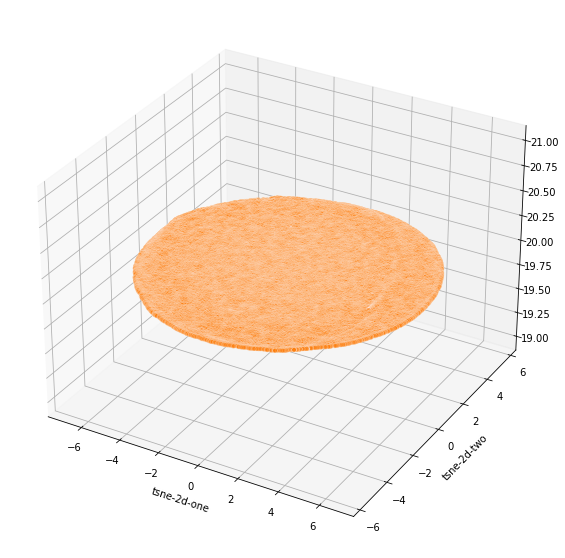

In [163]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax
)

As can be seen, due to the large ammount of tweets, the plot shows a dense subgraph in which we cannot extract much information. 
Let's create a subgroup of less tweets and check if there are clusters inside.

In [169]:
subgroup = list(tweet2vec.values())[0:100]
pca = PCA(n_components=3)
pca_result = pca.fit_transform(subgroup)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.34324853 0.21329392 0.14254927]


In [166]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result)

NameError: name 'z' is not defined

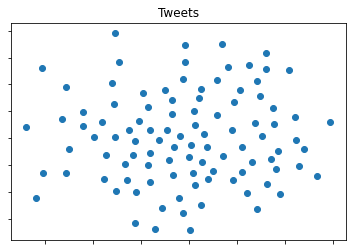

In [170]:
#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(tsne_pca_results[:,0], tsne_pca_results[:,1], 'o')
ax.set_title('Tweets')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
for i, txt in enumerate(subgroup):
    ax.annotate(txt, (z[i], y[i]))
plt.show()

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.annotate()
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3,
    ax=ax
)